In [186]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [187]:
# load datasets into DataFrames
path = 'C:/Users/xinwa/OneDrive/Documents/Data Science/Capstone Project 2/data/'
salaries_by_college_type_df = pd.read_csv(path+'salaries_by_college_type_cleaned.csv')
salaries_by_region_df = pd.read_csv(path+'salaries_by_region_cleaned.csv')


In [188]:
salaries_by_college_type_df.shape, salaries_by_region_df.shape

((269, 6), (320, 6))

In [189]:
salaries_by_college_type_df.columns, salaries_by_region_df.columns

(Index(['School Name', 'School Type', 'Starting Median Salary',
        'Mid-Career Median Salary', 'Mid-Career 25th Percentile Salary',
        'Mid-Career 75th Percentile Salary'],
       dtype='object'),
 Index(['School Name', 'Region', 'Starting Median Salary',
        'Mid-Career Median Salary', 'Mid-Career 25th Percentile Salary',
        'Mid-Career 75th Percentile Salary'],
       dtype='object'))

In [190]:
school_names = set(salaries_by_college_type_df['School Name']).intersection(set(salaries_by_region_df['School Name']))
len(school_names)

248

In [191]:
salaries_by_college_type_df['School Name'].isin(school_names).sum()

268

In [192]:
salaries_by_region_df['School Name'].isin(school_names).sum()

248

In [193]:
merged_college_type_region_df = salaries_by_college_type_df.merge(salaries_by_region_df, how='inner', \
                                                                 on = ['School Name', 'Starting Median Salary', \
                                                                       'Mid-Career Median Salary', \
                                                                       'Mid-Career 25th Percentile Salary', \
                                                                       'Mid-Career 75th Percentile Salary'])
merged_college_type_region_df.head()


,School Name,School Type,Starting Median Salary,Mid-Career Median Salary,Mid-Career 25th Percentile Salary,Mid-Career 75th Percentile Salary,Region
0,Massachusetts Institute of Technology (MIT),Engineering,72200.0,126000.0,99200.0,168000.0,Northeastern
1,California Institute of Technology (CIT),Engineering,75500.0,123000.0,104000.0,161000.0,California
2,Harvey Mudd College,Engineering,71800.0,122000.0,96000.0,180000.0,California
3,"Polytechnic University of New York, Brooklyn",Engineering,62400.0,114000.0,94300.0,143000.0,Northeastern
4,Cooper Union,Engineering,62200.0,114000.0,80200.0,142000.0,Northeastern


In [194]:
merged_college_type_region_df.shape

(266, 7)

In [195]:
merged_college_type_region_df.columns

Index(['School Name', 'School Type', 'Starting Median Salary',
       'Mid-Career Median Salary', 'Mid-Career 25th Percentile Salary',
       'Mid-Career 75th Percentile Salary', 'Region'],
      dtype='object')

In [196]:
# Linear Regression model without scaling and categorical columns
X = merged_college_type_region_df.drop(['School Name', 'School Type', 'Region', 'Mid-Career Median Salary'], axis=1)
y = merged_college_type_region_df['Mid-Career Median Salary']
#trian/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [197]:
# fit model on training data, make prediction on testing data and print metrics for model
def model_test(models, X_train, X_test, y_train, y_test):
    metrics_results = {}
    for model in models:
       models[model].fit(X_train, y_train)
       y_pred = models[model].predict(X_test)
       metrics_results[model] = {'r2_score': metrics.r2_score(y_test, y_pred), \
                                 'Mean absolute error': metrics.mean_absolute_error(y_test, y_pred), \
                                 'Mean squared error': metrics.mean_squared_error(y_test, y_pred), \
                                 'Square root of mean squared error': np.sqrt(metrics.mean_squared_error(y_test, y_pred)) \
                                }
    return pd.DataFrame(metrics_results)

In [198]:
# models with default settings and train and test on original data

models = {'OLS' : LinearRegression(), \
          'Lasso' : Lasso(), \
          'Ridge' : Ridge(), \
          'RandomForest' : RandomForestRegressor(random_state=42)\
         }
model_test(models, X_train, X_test, y_train, y_test)

,OLS,Lasso,Ridge,RandomForest
r2_score,9.433246e-01,9.433246e-01,9.433246e-01,9.413068e-01
Mean absolute error,2.234160e+03,2.234160e+03,2.234160e+03,2.295450e+03
Mean squared error,9.537031e+06,9.537031e+06,9.537031e+06,9.876582e+06
Square root of mean squared error,3.088208e+03,3.088208e+03,3.088208e+03,3.142703e+03


In [199]:
# models with default settings and train and test on scaled data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
model_test(models, X_train_scaled, X_test_scaled, y_train, y_test)

,OLS,Lasso,Ridge,RandomForest
r2_score,9.433246e-01,9.433256e-01,9.433451e-01,9.391075e-01
Mean absolute error,2.234160e+03,2.234201e+03,2.235478e+03,2.368213e+03
Mean squared error,9.537031e+06,9.536871e+06,9.533588e+06,1.024667e+07
Square root of mean squared error,3.088208e+03,3.088182e+03,3.087651e+03,3.201042e+03


In [200]:
def gridsearchcv(estimator, param_grid, X_train, y_train):
    grid = GridSearchCV(estimator, param_grid = param_grid)
    grid.fit(X_train, y_train)
    return grid.best_params_, grid.best_estimator_

In [201]:
# Using GridSearchCV to tune hyperparameters for models 
lasso_alpha = {'alpha': [0.001, 0.005, 0.015, 0.025, 0.035, 0.045, 0.055,  1, 1.5, 2.5, 3, 5, 10]}
ridge_alpha = {'alpha': [0, 0.1, 0.5, 1, 10, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]}
rf_params = {'n_estimators': [3, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200]}
lasso_best_params, lasso_best_estimator = gridsearchcv(Lasso(), lasso_alpha, X_train_scaled, y_train)
ridge_best_params, ridge_best_estimator = gridsearchcv(Ridge(), ridge_alpha, X_train_scaled, y_train)
rf_best_params, rf_best_estimator = gridsearchcv(RandomForestRegressor(random_state=42), rf_params, X_train, y_train)
(lasso_best_params, lasso_best_estimator), (ridge_best_params, ridge_best_estimator), (rf_best_params, rf_best_estimator)

(({'alpha': 1}, Lasso(alpha=1)),
 ({'alpha': 1}, Ridge(alpha=1)),
 ({'n_estimators': 40},
  RandomForestRegressor(n_estimators=40, random_state=42)))

In [202]:
models_tuned = {'OLS' : LinearRegression(), \
          'Lasso' : lasso_best_estimator, \
          'Ridge' : ridge_best_estimator,  \
          'RandomForest' : rf_best_estimator  \
         }
model_test(models, X_train_scaled, X_test_scaled, y_train, y_test)

,OLS,Lasso,Ridge,RandomForest
r2_score,9.433246e-01,9.433256e-01,9.433451e-01,9.391075e-01
Mean absolute error,2.234160e+03,2.234201e+03,2.235478e+03,2.368213e+03
Mean squared error,9.537031e+06,9.536871e+06,9.533588e+06,1.024667e+07
Square root of mean squared error,3.088208e+03,3.088182e+03,3.087651e+03,3.201042e+03


Conclusion: 
By observing the metrics for different models, we can conclude that Linear Models perform better than Random Forest Models.

<AxesSubplot:>

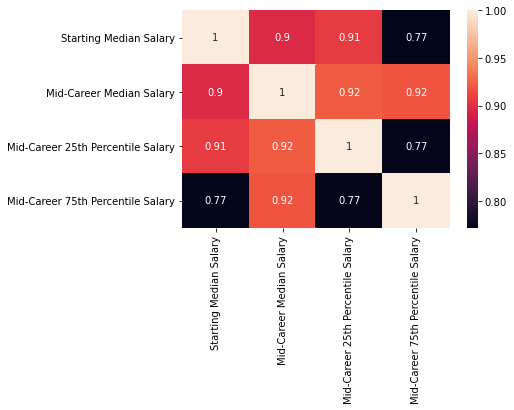

In [203]:
sns.heatmap(merged_college_type_region_df.corr(), annot=True)

In [204]:
#use Starting Median Salary predicting Mid-Career Median Salary by Linear Model
X_train.columns

Index(['Starting Median Salary', 'Mid-Career 25th Percentile Salary',
       'Mid-Career 75th Percentile Salary'],
      dtype='object')

In [205]:
X_median_train = X_train[['Starting Median Salary']]
X_median_test = X_test[['Starting Median Salary']]

In [206]:
model = {'OLS':LinearRegression()}
model_test(model, X_median_train, X_median_test, y_train, y_test)

,OLS
Mean absolute error,4.593745e+03
Mean squared error,3.672695e+07
Square root of mean squared error,6.060276e+03
r2_score,7.817441e-01


In [207]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(SelectKBest(f_regression), \
                    LinearRegression())
#pipe.fit(X_median_train, y_train)
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'selectkbest', 'linearregression', 'selectkbest__k', 'selectkbest__score_func', 'linearregression__copy_X', 'linearregression__fit_intercept', 'linearregression__n_jobs', 'linearregression__normalize'])

In [208]:
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k' : k}
lm_grid_cv = GridSearchCV(pipe, param_grid=grid_params, cv = 5, n_jobs = -1)
lm_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x0000024A6F2720D0>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1, param_grid={'selectkbest__k': [1, 2, 3]})

In [209]:
best_k = lm_grid_cv.best_params_
estimator = lm_grid_cv.best_estimator_
best_k, estimator

({'selectkbest__k': 3},
 Pipeline(steps=[('selectkbest',
                  SelectKBest(k=3,
                              score_func=<function f_regression at 0x0000024A6F2720D0>)),
                 ('linearregression', LinearRegression())]))

In [210]:
# selected = lm_grid_cv.best_estimator_.named_steps.selectkbest.get_support()
features = X_train.columns[selected]
coefs = lm_grid_cv.best_estimator_.named_steps.linearregression.coef_
pd.Series(coefs, index=features).sort_values(ascending=False)

Mid-Career 25th Percentile Salary    0.501139
Starting Median Salary               0.351198
Mid-Career 75th Percentile Salary    0.308018
dtype: float64